In [1]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [4]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 2min 16s, sys: 4.68 s, total: 2min 21s
Wall time: 2min 20s


# Подсчет статистики по интервалам

# Shin

In [81]:
def find_intervals(vector):
    intervals = []
    start = None

    for i, val in enumerate(vector):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            intervals.append(i - start)
            start = None

    if start is not None:
        intervals.append(len(vector) - start)

    return intervals

In [11]:
width_in = 5000
all_intervals = []
for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width_in, width_in):
        interval = [st, min(st + width_in, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            all_intervals.extend(find_intervals(ZDNA[chrm][interval[0]: interval[1]]))

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 9679.16it/s]


In [12]:
if all_intervals:
    average_length = np.mean(all_intervals)
    min_length = np.min(all_intervals)
    max_length = np.max(all_intervals)
    median_length = np.median(all_intervals)

    print(f'Средний размер интервала: {average_length}')
    print(f'Минимальный размер интервала: {min_length}')
    print(f'Максимальный размер интервала: {max_length}')
    print(f'Медианный размер интервала: {median_length}')
    print(f'Количество интервалов: {len(all_intervals)}')
else:
    print('Интервалы не найдены')

Средний размер интервала: 353.6348039215686
Минимальный размер интервала: 3
Максимальный размер интервала: 551
Медианный размер интервала: 385.0
Количество интервалов: 408


# Кузин

In [82]:
width_in = 5000
all_intervals = []
for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width_in, width_in):
        interval = [st, min(st + width_in, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            all_intervals.extend(find_intervals(ZDNA[chrm][interval[0]: interval[1]]))

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16867.17it/s]


In [83]:
if all_intervals:
    average_length = np.mean(all_intervals)
    min_length = np.min(all_intervals)
    max_length = np.max(all_intervals)
    median_length = np.median(all_intervals)

    print(f'Средний размер интервала: {average_length}')
    print(f'Минимальный размер интервала: {min_length}')
    print(f'Максимальный размер интервала: {max_length}')
    print(f'Медианный размер интервала: {median_length}')
    print(f'Количество интервалов: {len(all_intervals)}')
else:
    print('Интервалы не найдены')

Средний размер интервала: 19.700840990856804
Минимальный размер интервала: 1
Максимальный размер интервала: 1745
Медианный размер интервала: 18.0
Количество интервалов: 43639


# Data selection

In [5]:
width = 200

ei_1 = [[],[]]
for i in range(width-1):
    ei_1[0].append(i)
    ei_1[0].append(i+1)
    ei_1[1].append(i+1)
    ei_1[1].append(i)

edge = torch.tensor(np.array(ei_1), dtype=torch.long)

In [6]:
class GraphDataset(Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels, intervals,
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels = labels
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

        super().__init__(transform, pre_transform, pre_filter)

    def len(self):
        return len(self.intervals)

    def get(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)


        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)

        return Data(x=X.unsqueeze(0), y=y.unsqueeze(0))

In [7]:
np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 39351.59it/s]


In [8]:
np.random.seed(42)
equalized = ints_in #np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [9]:
np.random.seed(42)
train_dataset = GraphDataset(chrom_names, feature_names,
                            DNA, DNA_features,
                            ZDNA, train_intervals)

test_dataset = GraphDataset(chrom_names, feature_names,
                           DNA, DNA_features,
                           ZDNA, test_intervals)

In [10]:
np.random.seed(42)
params = {'batch_size':16,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# Train and test

In [11]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

np.random.seed(42)
def loss_func(output, y_batch):
    np.random.seed(42)
    return torch.nn.NLLLoss(weight=torch.tensor([1.0, 25.0]).cuda())(output, y_batch)


def train_epoch(model, optimizer):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()

    for dt in loader_train:
        x, y = dt.x.cuda(),  dt.y.cuda().long()
        
        optimizer.zero_grad()

        output = model(x)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred)
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
                          
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output.permute([0, 2, 1]), y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def test(model):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()

    means = []
    for dt in loader_test:
        x, y = dt.x.cuda(), dt.y.cuda().long()
        

        output = model(x)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=-1)
        
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()

        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    y_pred)
            
            precision = precision_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())

        loss = loss_func(output.permute([0, 2, 1]), y)
        loss = loss.item()
        loss_log.append(loss)

    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    np.random.seed(42)
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs):
    np.random.seed(42)
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        end_time = time.time()
        
        times.append(end_time - start_time)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))


        clear_output()
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss))
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))


    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times

In [12]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Model

In [13]:
class GraphZSAGEConv(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConv, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.conv2 = SAGEConv(500, 100)
        self.conv3 = SAGEConv(100, 2)

    def forward(self, x):
        x = self.conv1(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv3(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

In [14]:
class GraphZSAGEConvBatchNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvBatchNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.bn1 = torch.nn.BatchNorm1d(200)
        self.conv2 = SAGEConv(500, 100)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.conv3 = SAGEConv(100, 2)

    def forward(self, x):
        x = self.conv1(x, edge.cuda())
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge.cuda())
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

In [15]:
class GraphZSAGEConvLayerNorm(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConvLayerNorm, self).__init__()
        self.conv1 = SAGEConv(1950, 500)
        self.ln1 = torch.nn.LayerNorm(500)
        self.conv2 = SAGEConv(500, 100)
        self.ln2 = torch.nn.LayerNorm(100)
        self.conv3 = SAGEConv(100, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=-1)

# Запуск кузин

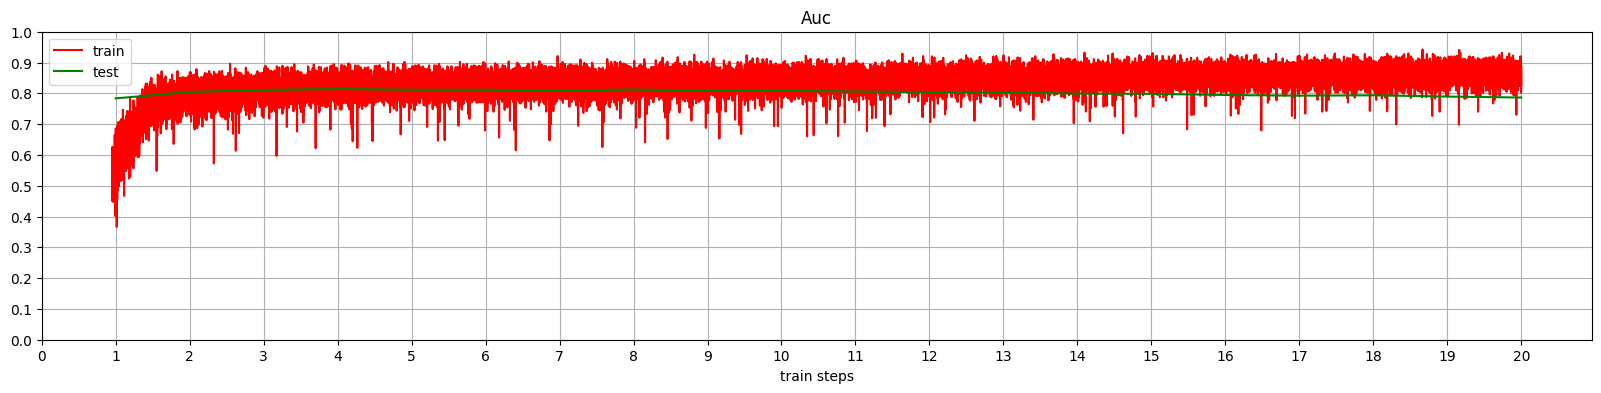

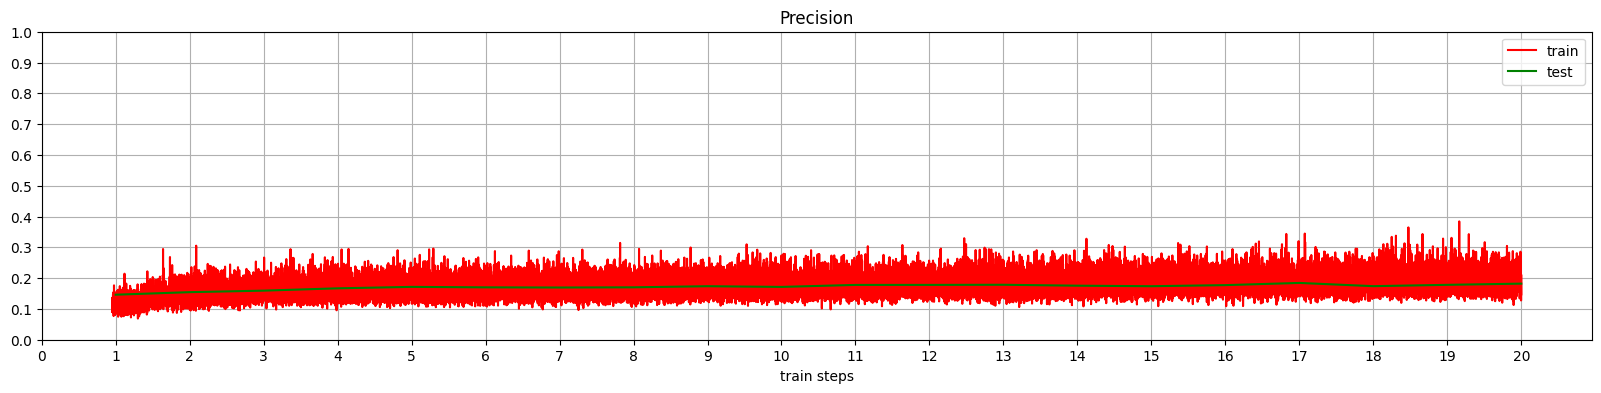

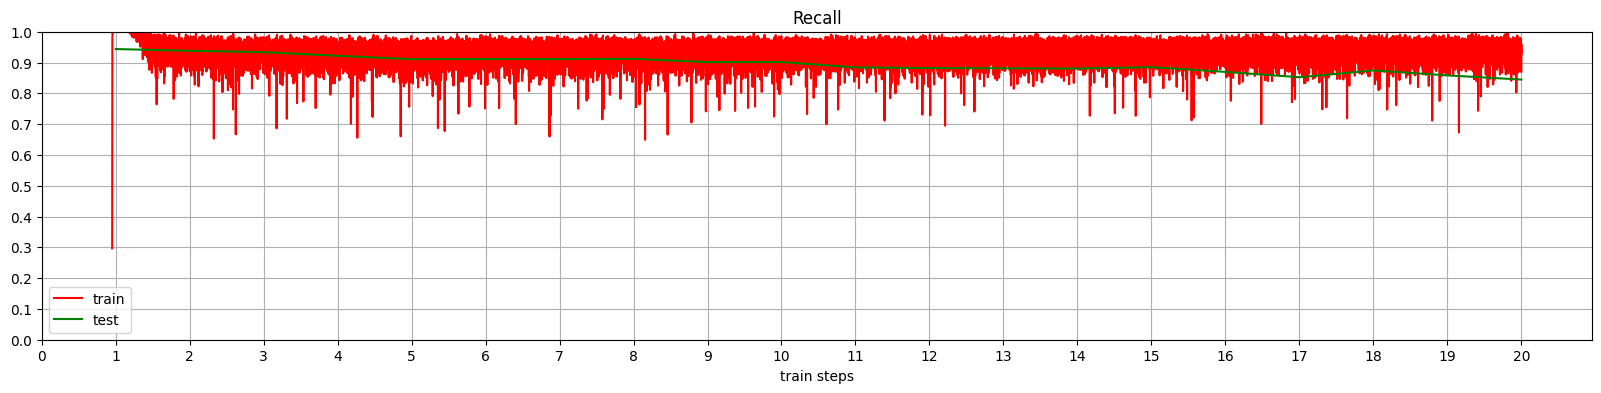

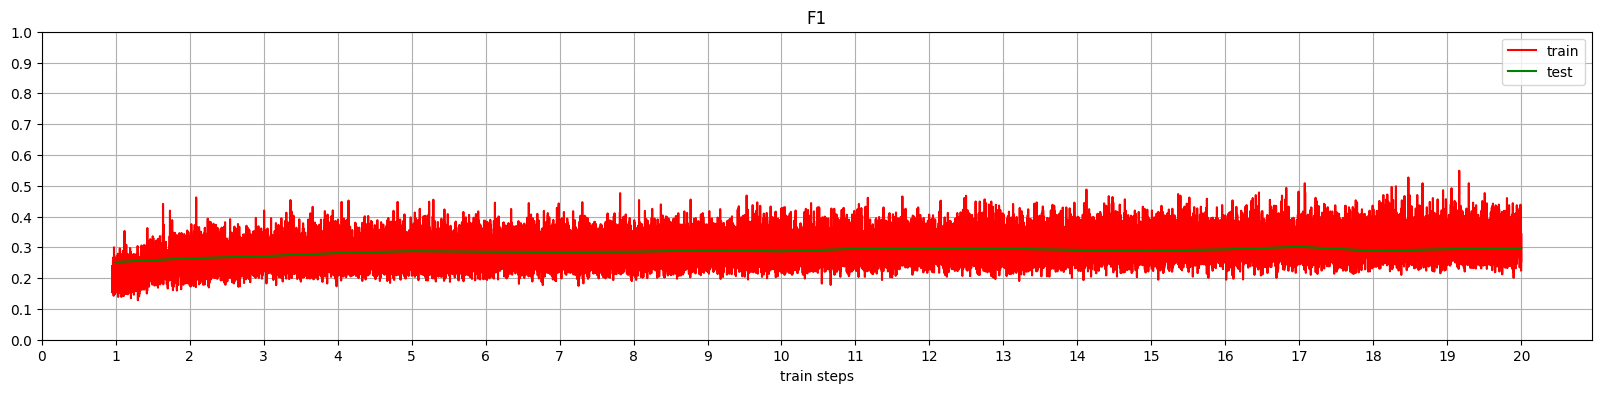

Epoch 20: ROC-AUC = 78.64%
Epoch 20: Precision = 0.182
Epoch 20: Recall = 0.845
Epoch 20: F1-score = 0.298
Final ROC-AUC = 78.64%
Final Precision = 0.182
Final Recall = 0.845
Final F1-score = 0.298
CPU times: user 39min 3s, sys: 10min 35s, total: 49min 38s
Wall time: 1h 34min 44s


In [147]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [148]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f}".format(np.mean(times)))

Epoch 16
Max F1-score: 0.3018
ROC-AUC: 0.7923
Precision: 0.1844
Recall: 0.8522
Mean time for 1 epoch 283.02


# Эксперименты с соседями

# 10 соседей подряд

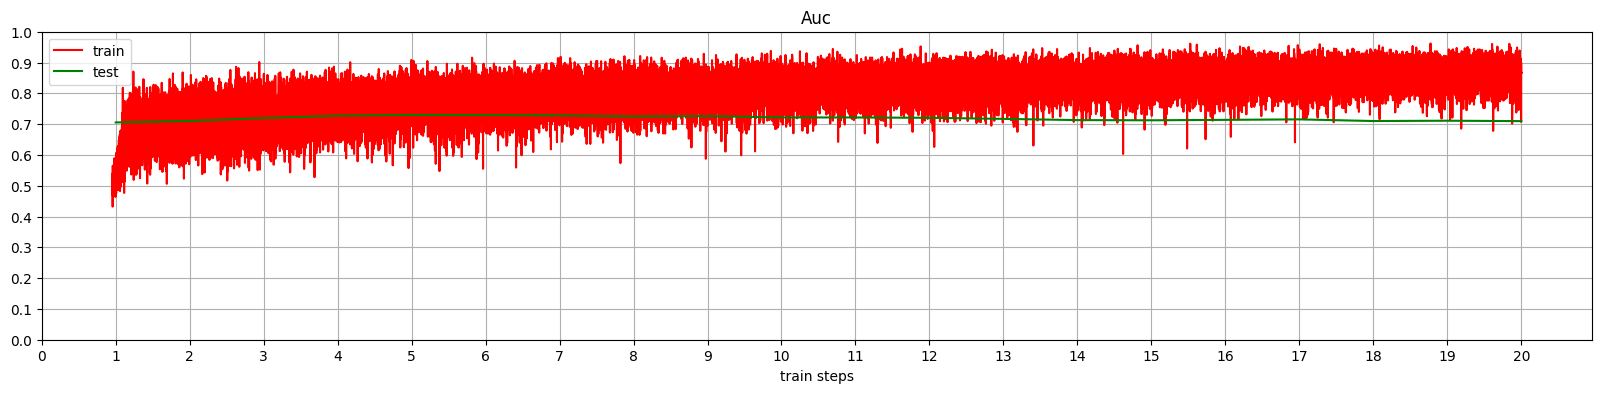

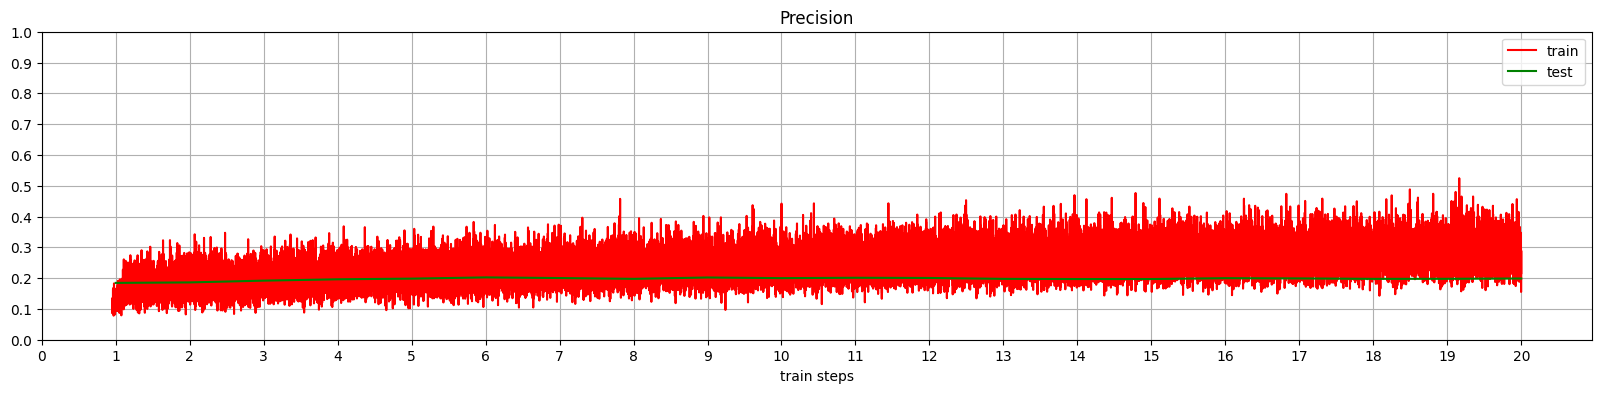

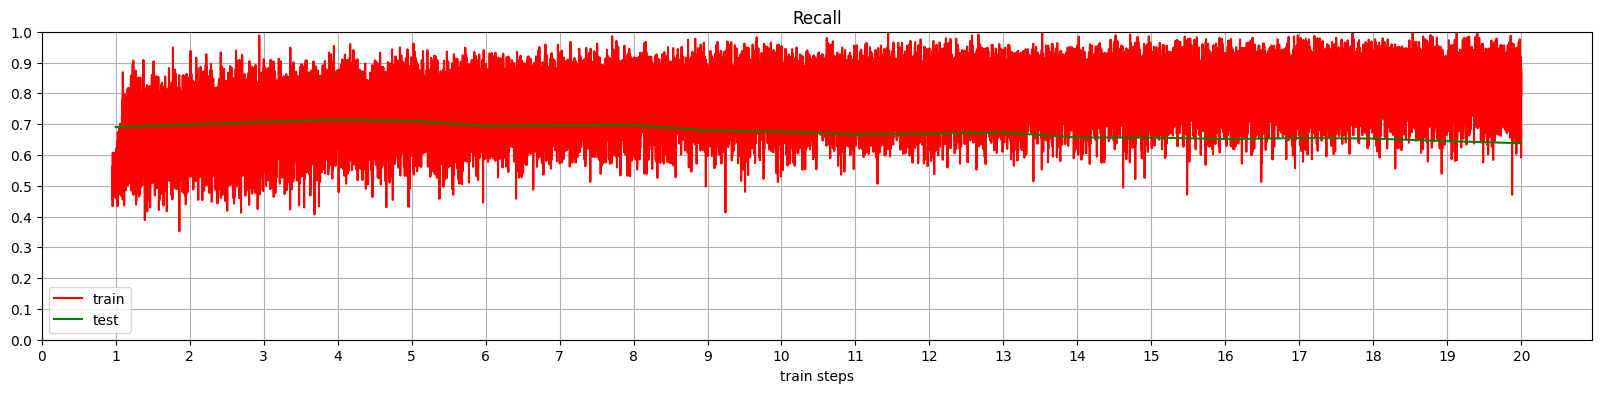

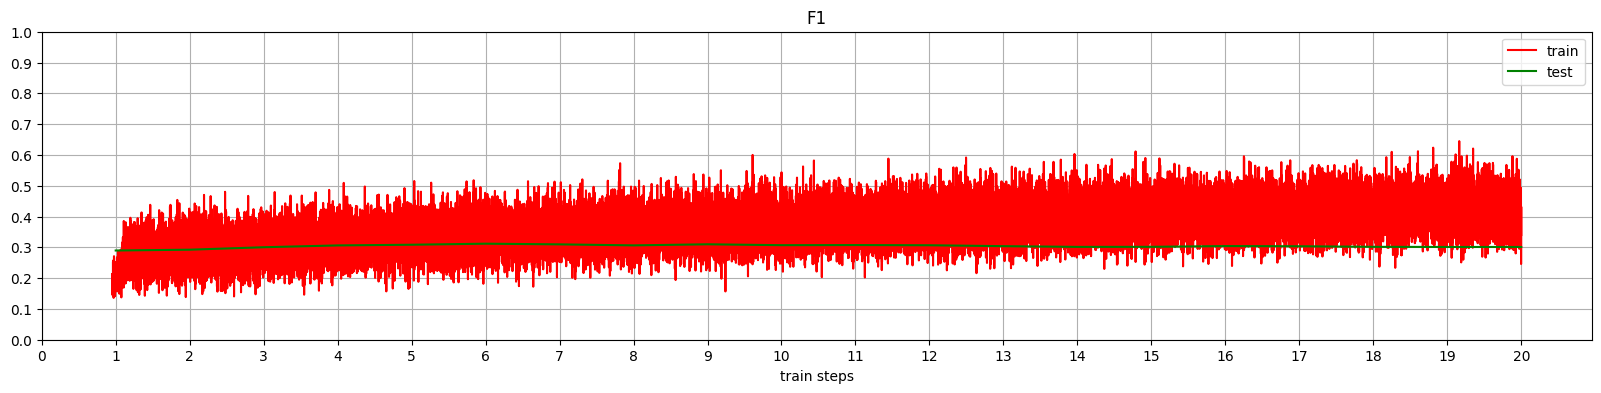

Epoch 20: ROC-AUC = 70.98%
Epoch 20: Precision = 0.199
Epoch 20: Recall = 0.638
Epoch 20: F1-score = 0.301
Final ROC-AUC = 70.98%
Final Precision = 0.199
Final Recall = 0.638
Final F1-score = 0.301
CPU times: user 41min 30s, sys: 9min 23s, total: 50min 54s
Wall time: 2h 28min 19s


In [25]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConvBatchNorm()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [30]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 31.1778%
ROC-AUC: 72.9306%
Precision: 0.2024
Recall: 0.6943
Mean time for 1 epoch 7.39 minutes


# 2 соседей подряд

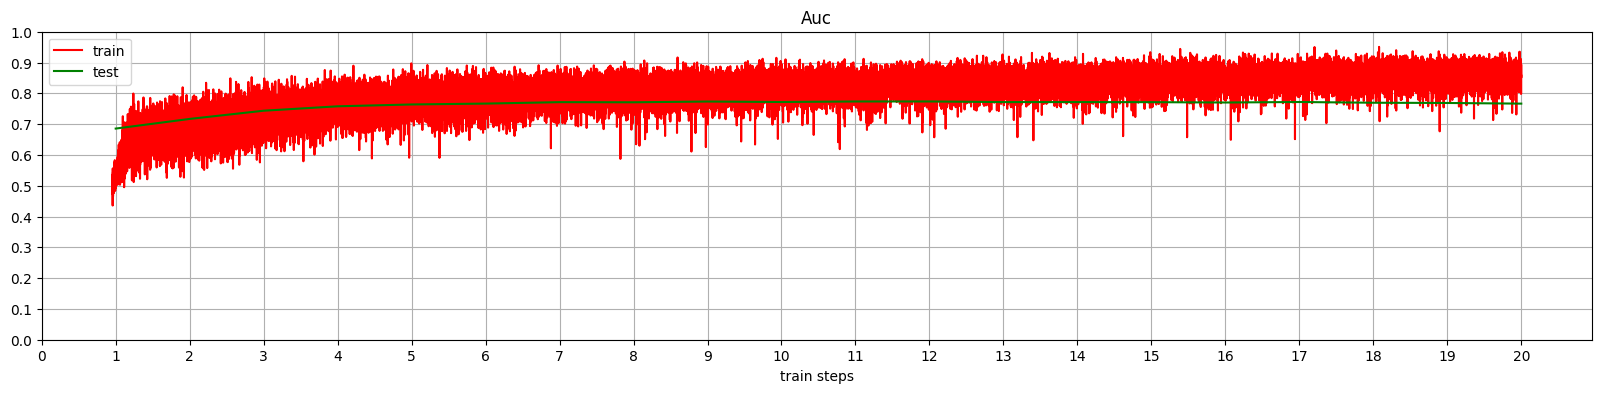

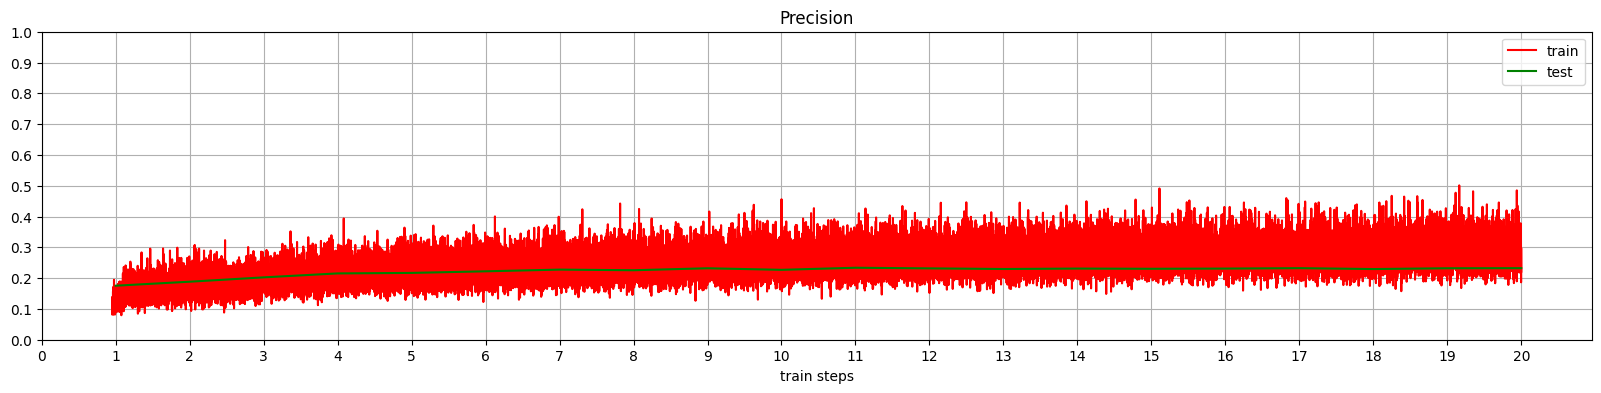

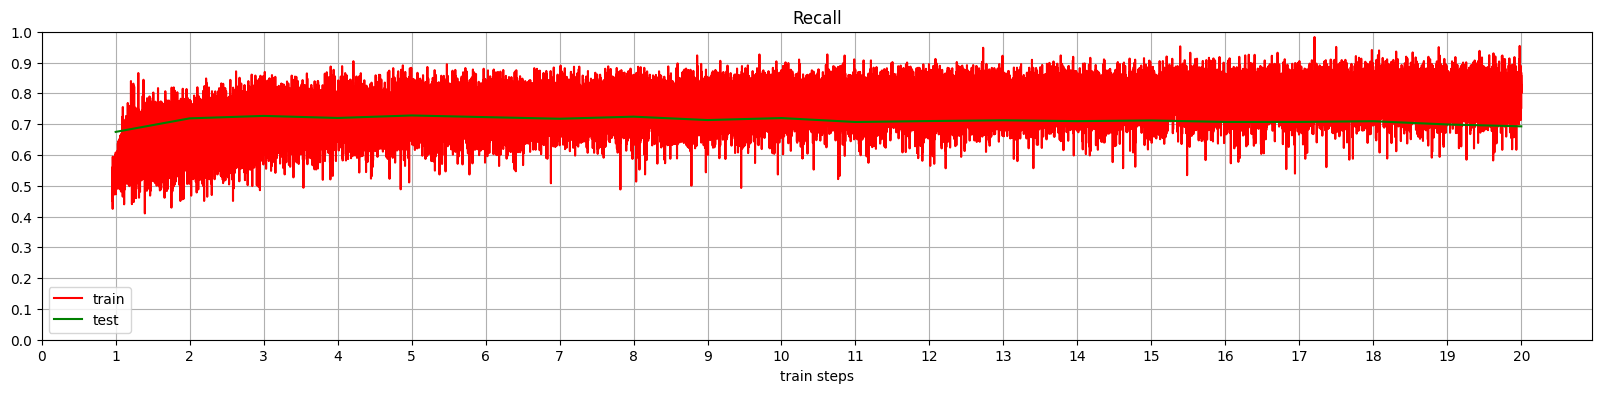

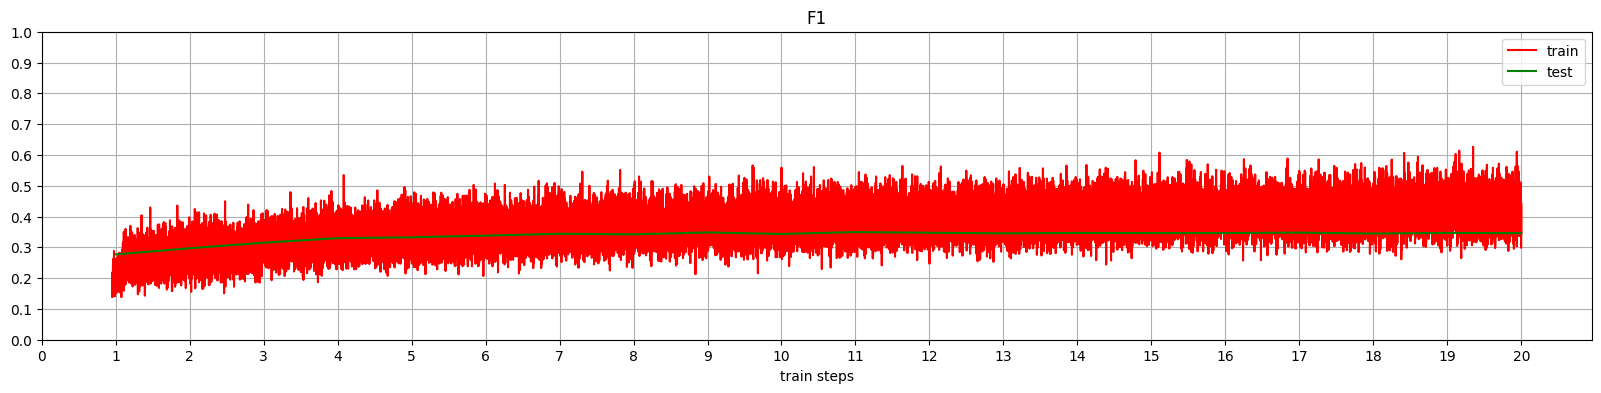

Epoch 20: ROC-AUC = 76.66%
Epoch 20: Precision = 0.232
Epoch 20: Recall = 0.693
Epoch 20: F1-score = 0.346
Final ROC-AUC = 76.66%
Final Precision = 0.232
Final Recall = 0.693
Final F1-score = 0.346
CPU times: user 35min 58s, sys: 7min 22s, total: 43min 21s
Wall time: 2h 46min 31s


In [42]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConvBatchNorm()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [43]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 34.9409%
ROC-AUC: 77.3544%
Precision: 0.2337
Recall: 0.7069
Mean time for 1 epoch 8.29 minutes


# Эксперименты с большими моделями

In [18]:
class GraphZSAGEConv_v2(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConv_v2, self).__init__()
        self.conv1 = SAGEConv(1950, 1600)
        self.conv2 = SAGEConv(1600, 1200)
        self.conv3 = SAGEConv(1200, 1000)
        self.conv4 = SAGEConv(1000, 800)
        self.conv5 = SAGEConv(800, 600)
        self.conv6 = SAGEConv(600, 400)
        self.conv7 = SAGEConv(400, 200)
        self.conv8 = SAGEConv(200, 100)
        self.conv9 = SAGEConv(100, 2)

    def forward(self, x):
        x = self.conv1(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv2(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv3(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv4(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv5(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv6(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv7(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv8(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv9(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

# Запуск GraphZSAGEConv_v2

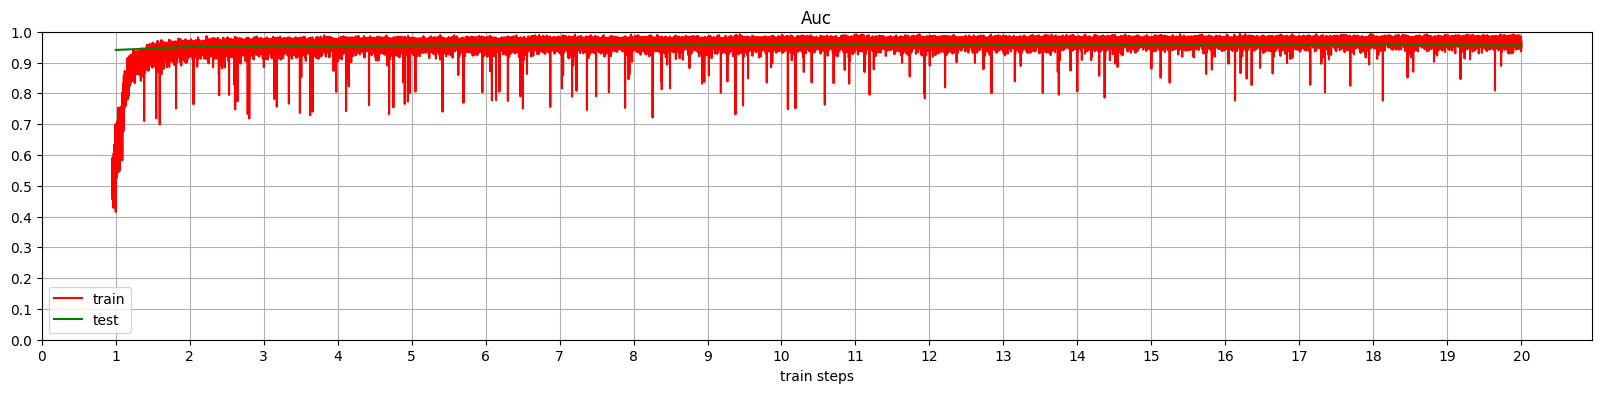

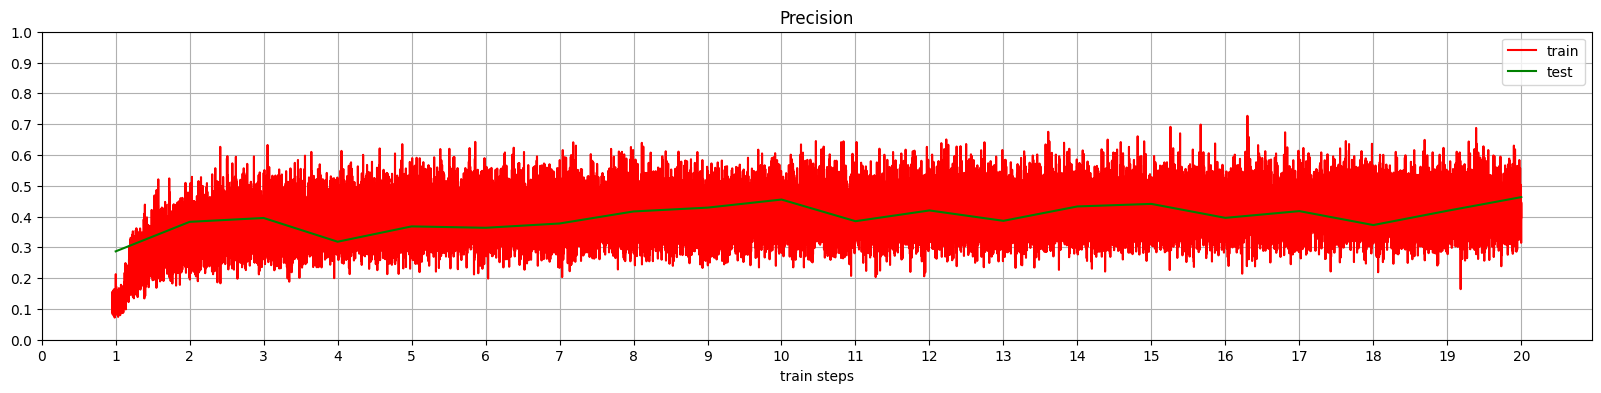

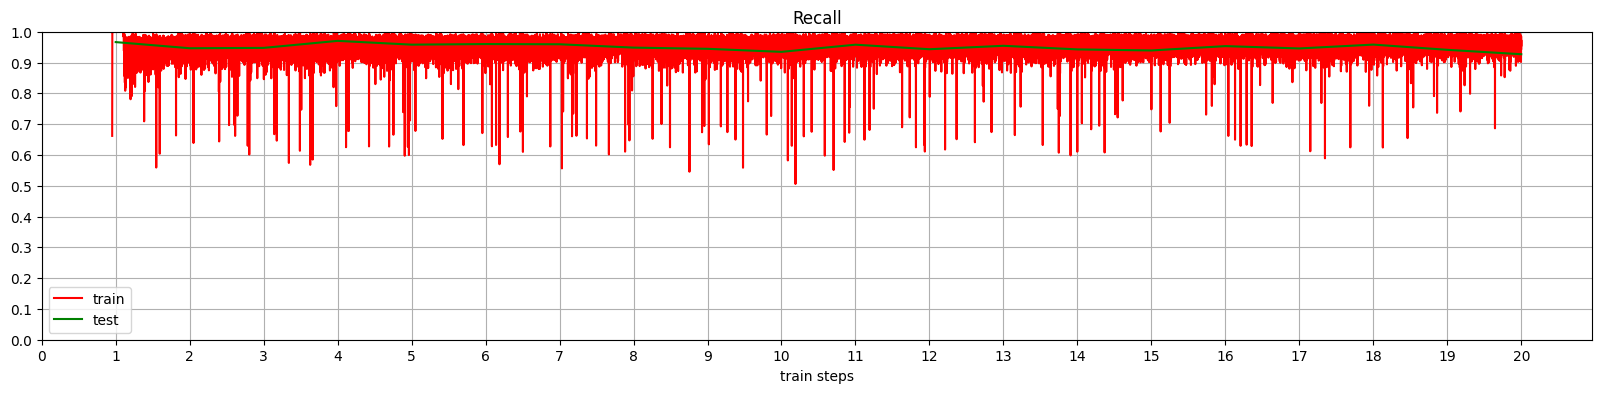

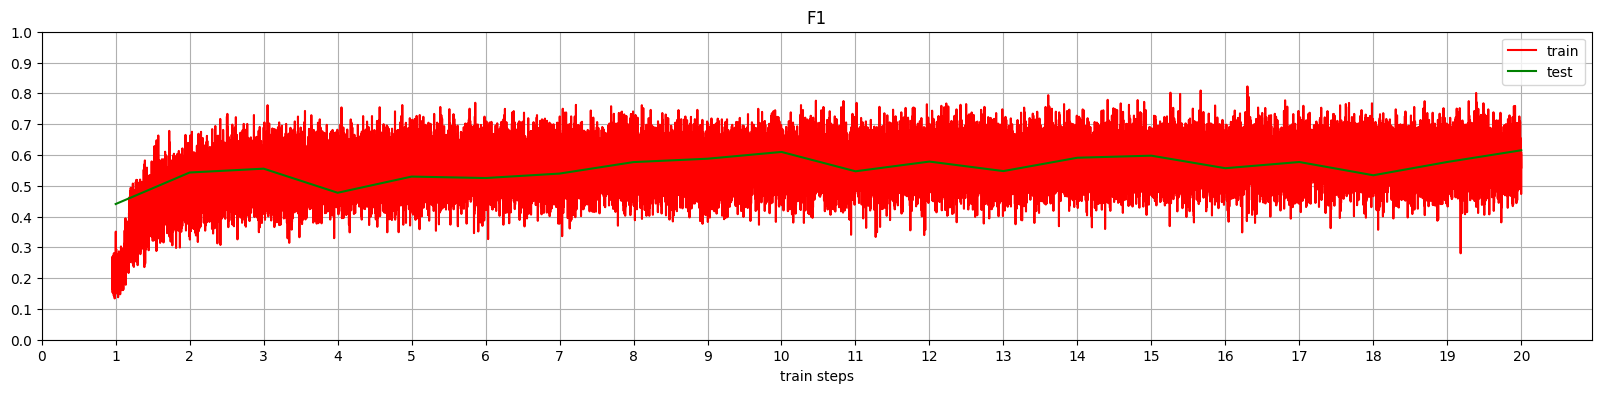

Epoch 20: ROC-AUC = 95.57%
Epoch 20: Precision = 0.463
Epoch 20: Recall = 0.927
Epoch 20: F1-score = 0.615
Final ROC-AUC = 95.57%
Final Precision = 0.463
Final Recall = 0.927
Final F1-score = 0.615
CPU times: user 1h 5min 46s, sys: 17min 5s, total: 1h 22min 51s
Wall time: 1h 42min 32s


In [19]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv_v2()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [21]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 19
Max F1-score: 61.5098%
ROC-AUC: 95.5667%
Precision: 0.4630
Recall: 0.9269
Mean time for 1 epoch 5.11 minutes


# Запуск GraphZSAGEConv_v3

In [35]:
class GraphZSAGEConv_v3(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConv_v3, self).__init__()
        self.conv1 = SAGEConv(1950, 1800)
        self.conv2 = SAGEConv(1800, 1600)
        self.conv3 = SAGEConv(1600, 1200)
        self.conv4 = SAGEConv(1200, 1000)
        self.conv5 = SAGEConv(1000, 800)
        self.conv6 = SAGEConv(800, 600)
        self.conv7 = SAGEConv(600, 400)
        self.conv8 = SAGEConv(400, 200)
        self.conv9 = SAGEConv(200, 100)
        self.conv10 = SAGEConv(100, 2)

    def forward(self, x):
        x = self.conv1(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv2(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv3(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv4(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv5(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv6(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv7(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv8(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv9(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv10(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

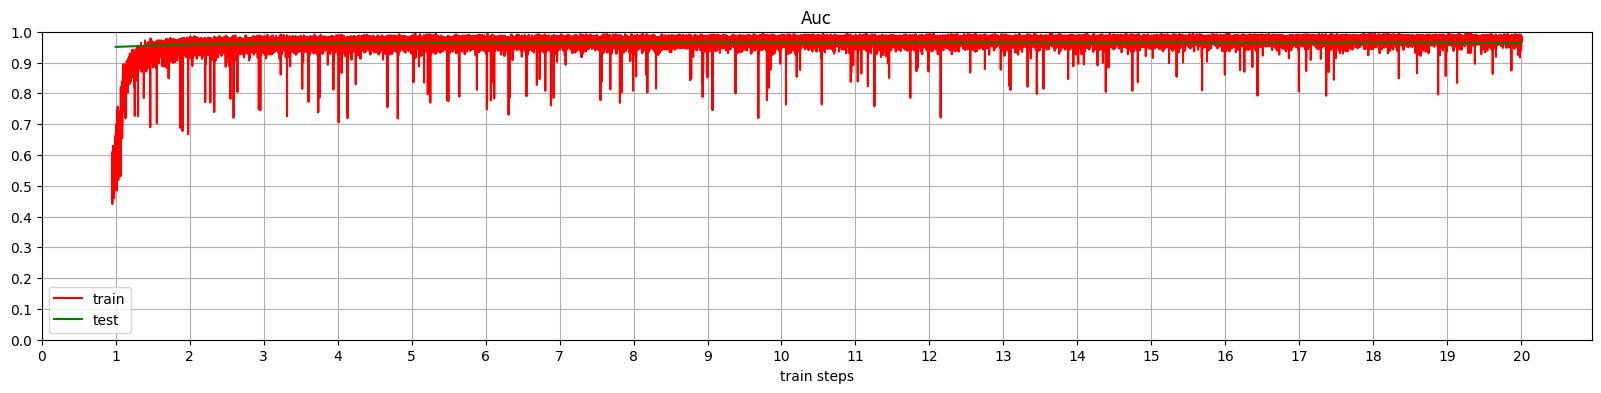

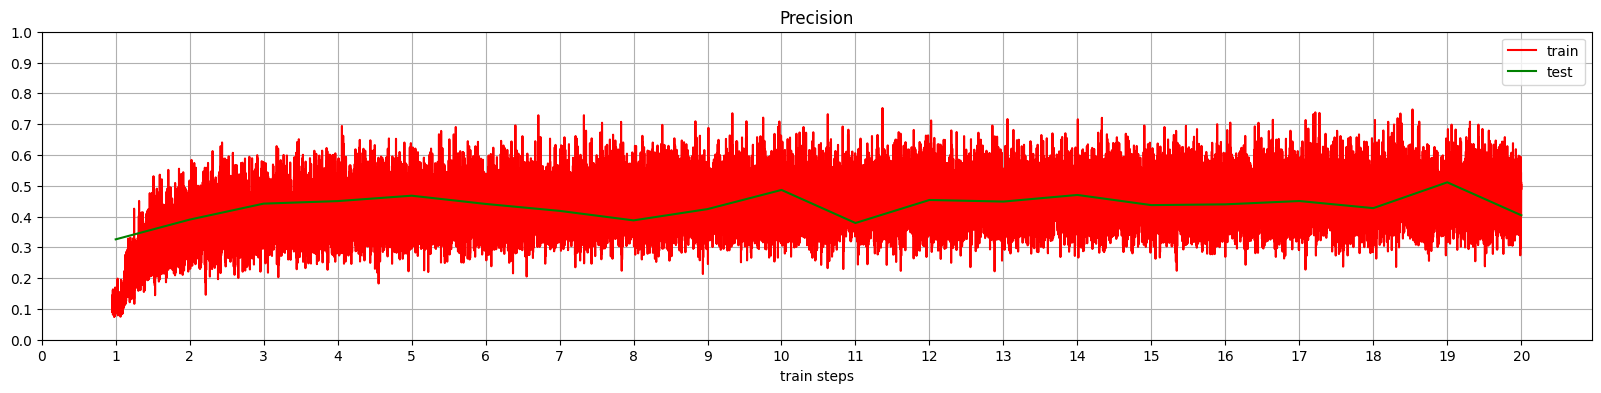

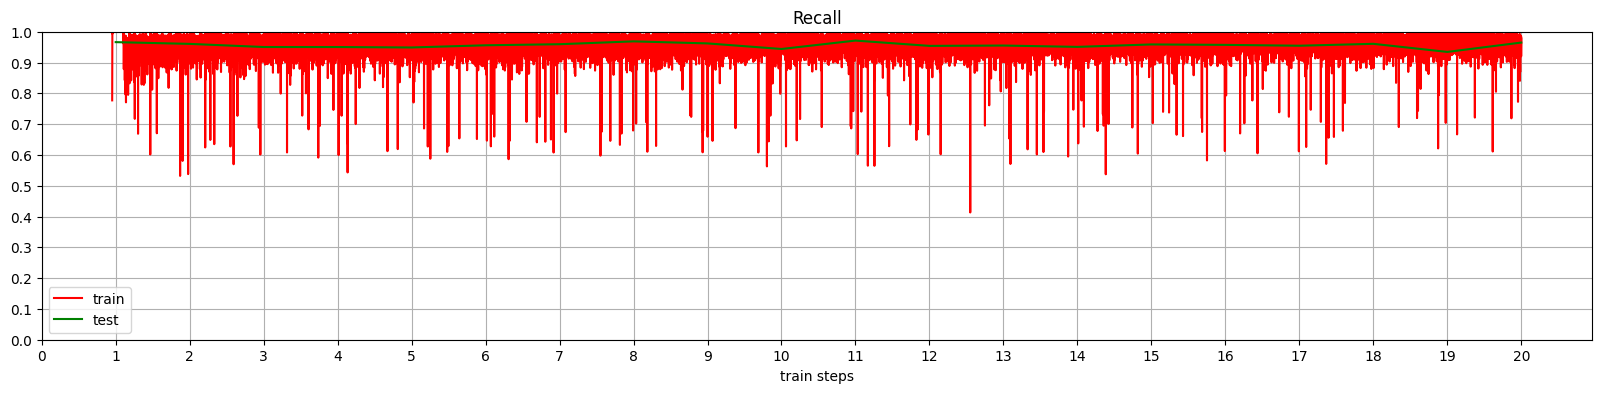

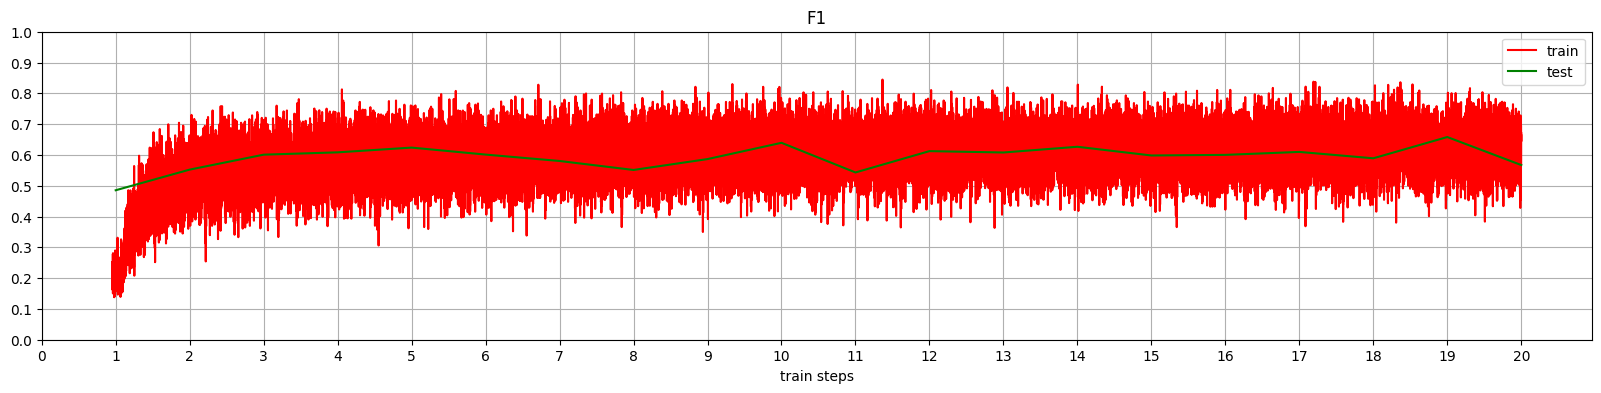

Epoch 20: ROC-AUC = 96.32%
Epoch 20: Precision = 0.404
Epoch 20: Recall = 0.965
Epoch 20: F1-score = 0.567
Final ROC-AUC = 96.32%
Final Precision = 0.404
Final Recall = 0.965
Final F1-score = 0.567
CPU times: user 1h 22min 18s, sys: 22min 7s, total: 1h 44min 26s
Wall time: 1h 54min 56s


In [23]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv_v3()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [24]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 18
Max F1-score: 65.8065%
ROC-AUC: 96.4556%
Precision: 0.5110
Recall: 0.9344
Mean time for 1 epoch 5.72 minutes


# 2 соседа + GraphZSAGEConv_v3

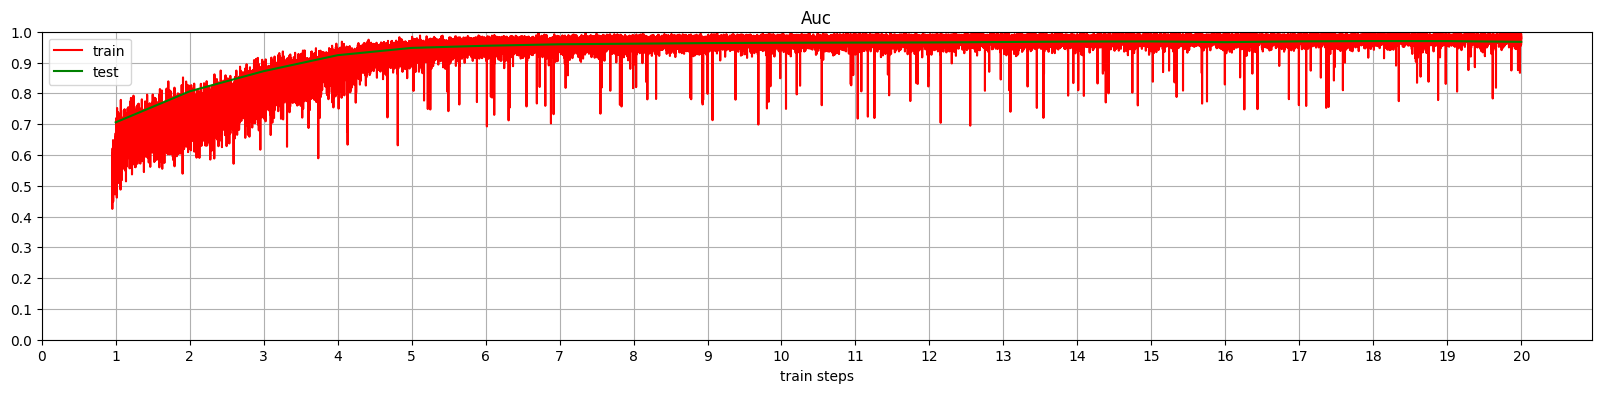

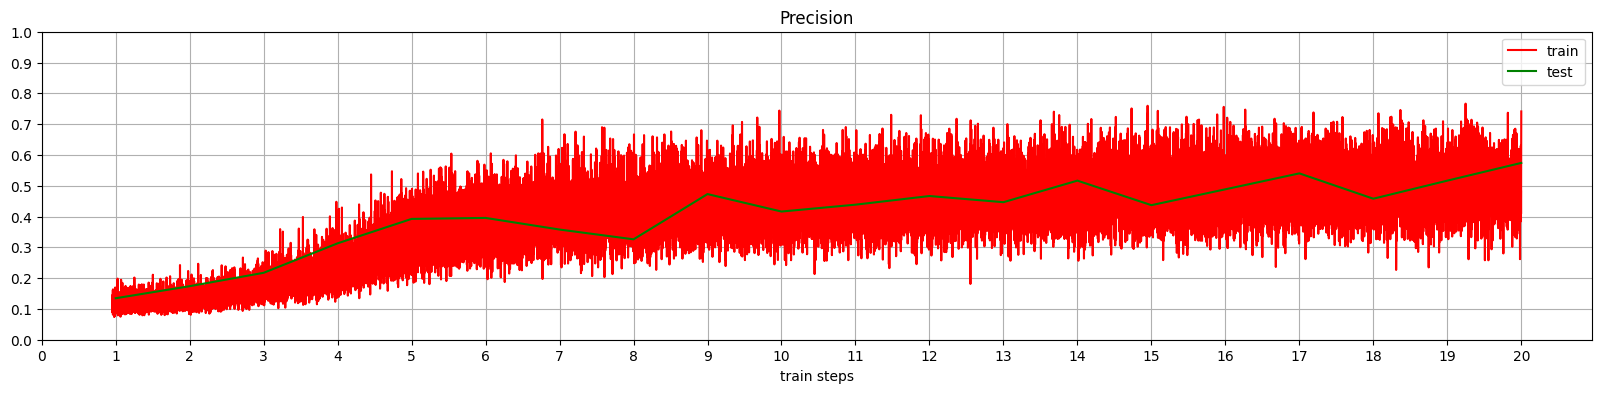

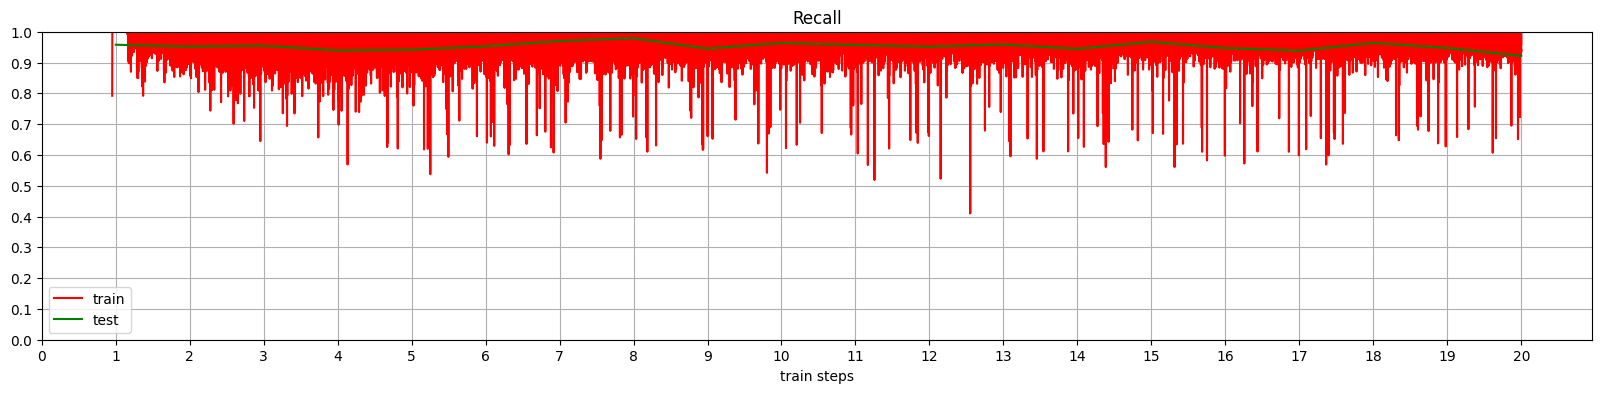

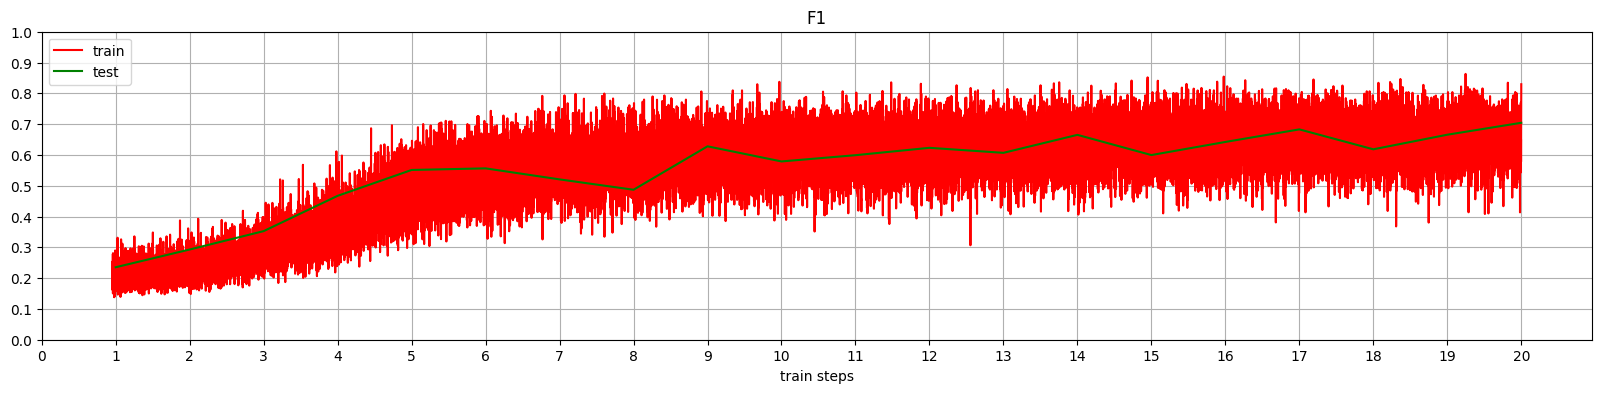

Epoch 20: ROC-AUC = 96.72%
Epoch 20: Precision = 0.574
Epoch 20: Recall = 0.922
Epoch 20: F1-score = 0.704
Final ROC-AUC = 96.72%
Final Precision = 0.574
Final Recall = 0.922
Final F1-score = 0.704
CPU times: user 2h 5min, sys: 34min 53s, total: 2h 39min 54s
Wall time: 2h 52min 12s


In [36]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv_v3()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 20)

In [37]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 19
Max F1-score: 70.4344%
ROC-AUC: 96.7173%
Precision: 0.5740
Recall: 0.9217
Mean time for 1 epoch 8.59 minutes


# Запуск GraphZSAGEConv_v4

In [16]:
class GraphZSAGEConv_v4(torch.nn.Module):
    def __init__(self):
        super(GraphZSAGEConv_v4, self).__init__()
        self.conv1 = SAGEConv(1950, 1900)
        self.conv2 = SAGEConv(1900, 1800)
        self.conv3 = SAGEConv(1800, 1700)
        self.conv4 = SAGEConv(1700, 1600)
        self.conv5 = SAGEConv(1600, 1500)
        self.conv6 = SAGEConv(1500, 1400)
        self.conv7 = SAGEConv(1400, 1300)
        self.conv8 = SAGEConv(1300, 1200)
        self.conv9 = SAGEConv(1200, 1100)
        self.conv10 = SAGEConv(1100, 1000)
        self.conv11 = SAGEConv(1000, 900)
        self.conv12 = SAGEConv(900, 800)
        self.conv13 = SAGEConv(800, 700)
        self.conv14 = SAGEConv(700, 600)
        self.conv15 = SAGEConv(600, 500)
        self.conv16 = SAGEConv(500, 400)
        self.conv17 = SAGEConv(400, 300)
        self.conv18 = SAGEConv(300, 200)
        self.conv19 = SAGEConv(200, 100)
        self.conv20 = SAGEConv(100, 2)

    def forward(self, x):
        x = self.conv1(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv2(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv3(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv4(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv5(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv6(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv7(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv8(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv9(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv10(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv11(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv12(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv13(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv14(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv15(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv16(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv17(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv18(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv19(x, edge.cuda())
        x = F.relu(x)
        x = F.dropout(x)
        
        x = self.conv20(x, edge.cuda())

        return F.log_softmax(x, dim=-1)

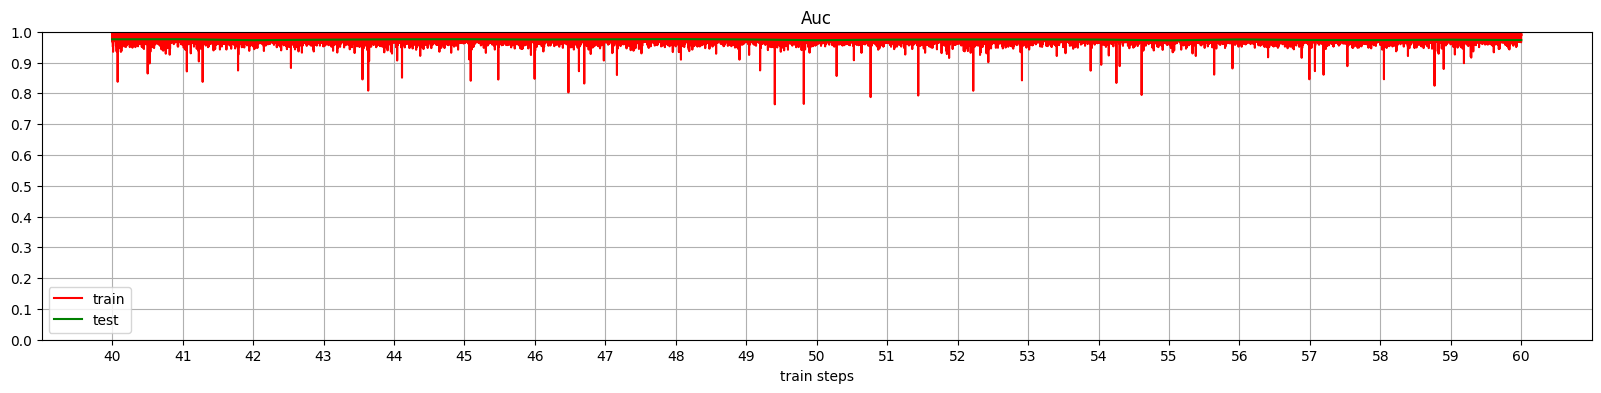

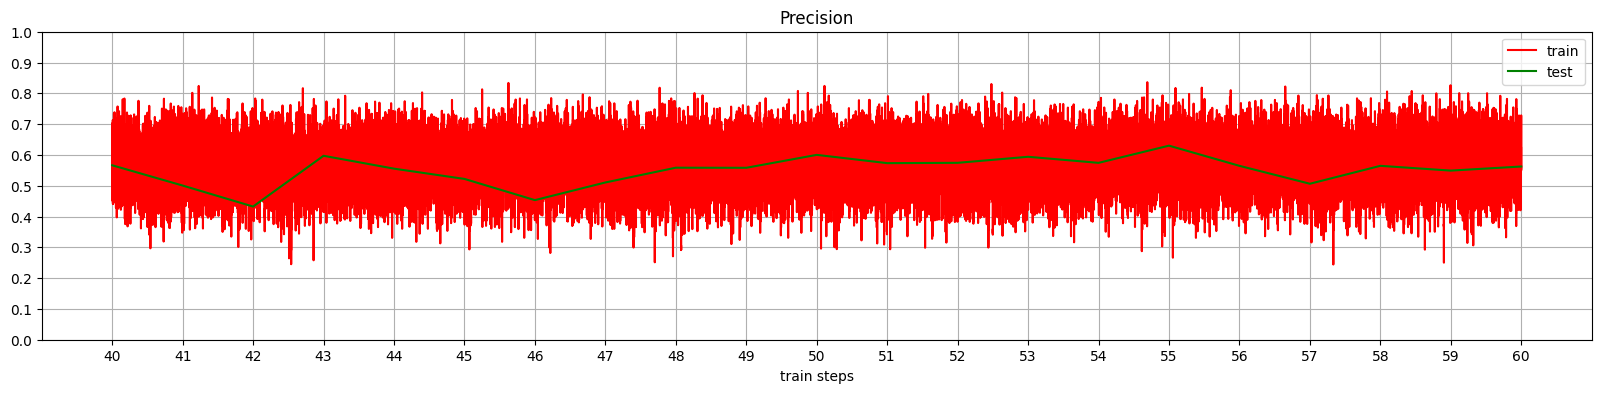

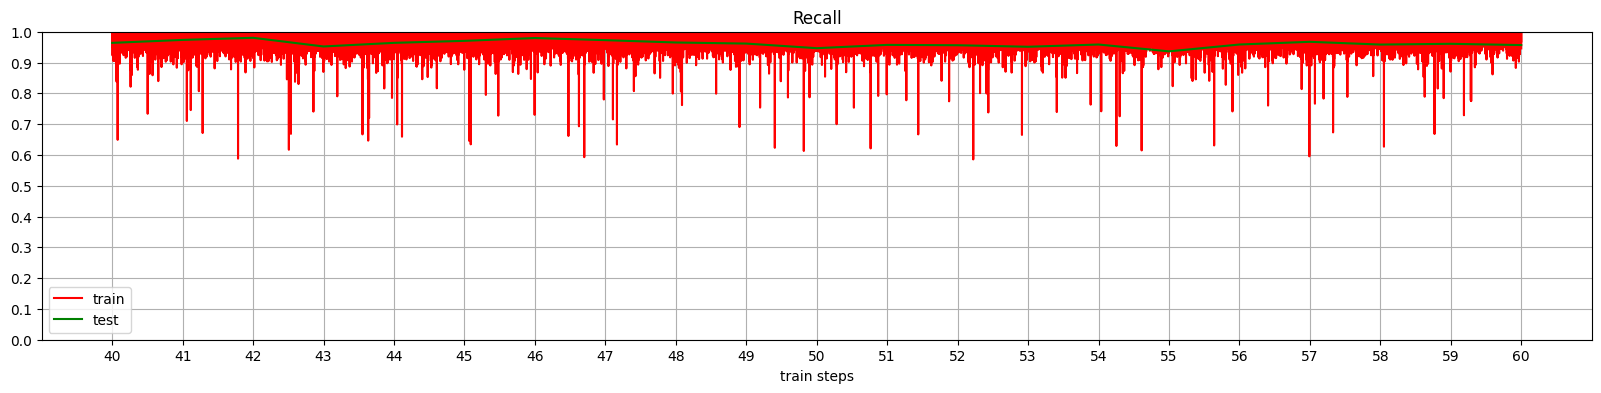

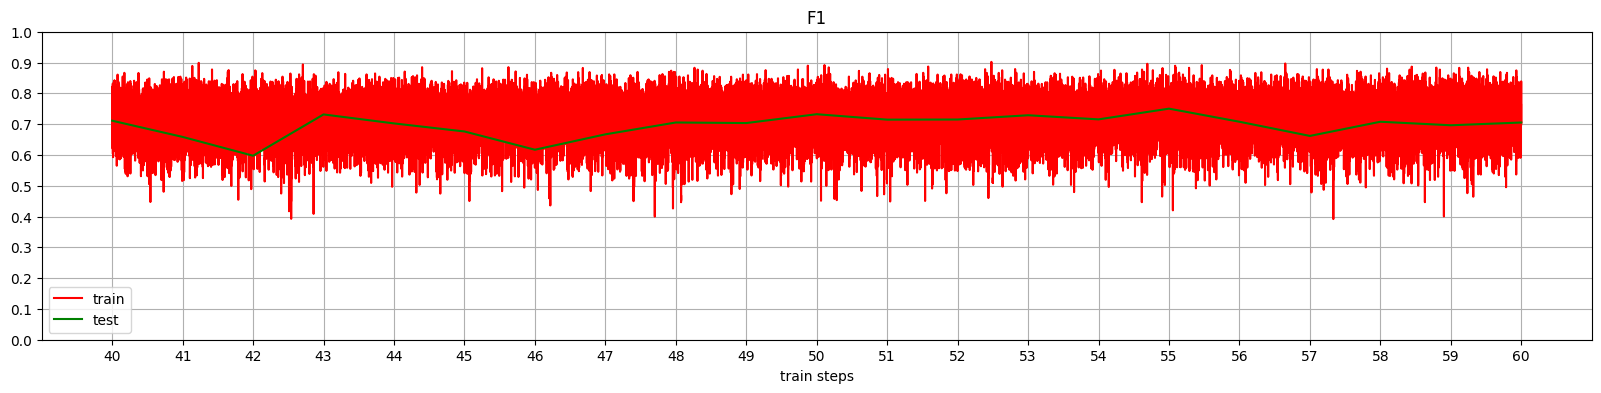

Epoch 60: ROC-AUC = 97.29%
Epoch 60: Precision = 0.562
Epoch 60: Recall = 0.957
Epoch 60: F1-score = 0.705
Final ROC-AUC = 97.29%
Final Precision = 0.562
Final Recall = 0.957
Final F1-score = 0.705
CPU times: user 12h 27min 17s, sys: 3h 44min 10s, total: 16h 11min 28s
Wall time: 16h 17min 9s


In [17]:
%%time
torch.cuda.empty_cache()
set_random_seed(42)

model = GraphZSAGEConv_v4()
model = model.to('cuda')

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 60)

In [18]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 54
Max F1-score: 75.0230%
ROC-AUC: 97.2173%
Precision: 0.6301
Recall: 0.9363
Mean time for 1 epoch 16.26 minutes
